# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

In [2]:
df_bike = pd.read_csv("./bikes.csv", index_col=0)
df_bike.sample(6)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
199,200,19-07-2018,autumn,0,7,0,2,1,1,31.843347,37.37395,65.0417,8.750200,752,3789,4541
167,168,17-06-2018,summer,0,6,0,5,1,1,26.615847,30.01915,73.5833,9.582943,863,3981,4844
228,229,17-08-2018,autumn,0,8,0,3,1,1,29.656653,33.33355,57.5417,9.625689,668,4026,4694
546,547,01-07-2019,autumn,1,7,0,0,0,1,33.449153,37.53145,51.8750,11.291443,1421,4110,5531
89,90,31-03-2018,summer,0,3,0,4,1,3,11.001653,12.87875,91.8333,14.582282,179,1506,1685
403,404,08-02-2019,spring,1,2,0,3,1,2,10.523347,13.32105,72.2917,8.959307,109,2693,2802


---------

In [98]:
df_bike.stb.counts().T

,yr,holiday,workingday,season_encoding,weathersit,season,wind_num_encoding,wind_interval,hum_interval_ord,hum_interval_num,hum_interval,temp_interval_num,temp_interval_ord,temp_interval,weekday,mnth,day,temp,hum,casual,windspeed,registered,cnt
count,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730
unique,2,2,2,3,3,4,5,5,5,5,5,5,5,5,7,12,31,252,394,605,649,678,695
most_freq,0,0,1,1,1,summer,1,low,4,"(58.32, 77.76]",high,"(22.14, 28.72]",4,high,6,1,01,27,59,120,9,4841,5409
most_freq_count,365,709,499,362,463,184,363,363,332,332,332,194,194,194,105,62,24,9,8,4,3,3,2
least_freq,0,1,0,2,3,winter,very_high,very_high,1,"(-0.0972, 19.44]",very_low,"(2.367, 8.98]",1,very_low,3,2,31,6,77,2290,4,3100,5740
least_freq_count,365,21,231,184,21,180,7,7,2,2,2,42,42,42,103,56,14,1,1,1,1,1,1


In [4]:
df_bike.describe()

,instant,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [5]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 97.0+ KB


> - <font color = violet> NO TENEMOS NULOS
> -  730 filas
> - 17 columnas
- **Holiday** : 1 = festivo / 0 = no festivo
- **Weekday** = 0 Domingo - 6 Sábado
- **Workingday** = 1 laborable / 0 finde
- **Weathersit** = grados en el readme
- **Temperatura** = 
- **Humedad** =
- **Viento** = 
- **Casual** = nº de usuarios no registrados/día
- **Registered** = nº de usuarios registrados/día
- **Total** = total de usuarios/día



# REVISIÓN DE COLUMNAS:

### 1. FECHA:
- Tenemos "yr" (año) y "mnth" (mes) y obtenemos "day" a través de la separación de "dteday", que posteriormente eliminaremos:

In [6]:
df_bike["day"] = df_bike["dteday"].str.split(pat= "-", n = -1, expand = True)[0]

In [7]:
df_bike=df_bike.reindex(columns=['instant', 'dteday', 'season', 'yr', 'mnth','day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'])

------

### 2. Columna "season"
- Corregir de acuerdo con las fechas.

In [8]:
df_bike['dteday'] = df_bike['dteday'].apply(pd.to_datetime)

In [9]:
def meses(x):
    a = x.month

    if  a >= 1 and a<=3:
        return 'winter'
    elif a >= 4 and a<=6:
        return 'spring'
    elif a >= 7 and a<=9:
        return 'summer'
    else:
        return 'autumn'

In [10]:
df_bike['season'] = df_bike['dteday'].apply(meses)

In [11]:
df_bike.sample(5)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
73,74,2018-03-15,winter,0,3,15,0,2,1,2,13.013031,15.90890,65.5652,12.348703,289,1767,2056
672,673,2019-04-11,spring,1,11,04,0,0,0,1,13.359153,16.47690,53.2917,12.000236,1201,3906,5107
182,183,2018-02-07,winter,0,7,02,0,6,0,1,30.271653,33.36540,44.4583,7.709154,2204,2915,5119
172,173,2018-06-22,spring,0,6,22,0,3,1,1,30.066653,34.69145,70.7500,11.541554,661,3846,4507
693,694,2019-11-25,autumn,1,11,25,0,0,0,1,10.079153,12.87915,46.8333,10.083500,309,2115,2424


 - Antes de codificarla hacemos una gráfica para ver cómo se reparte el alquiler de bicicletas durante las estaciones.

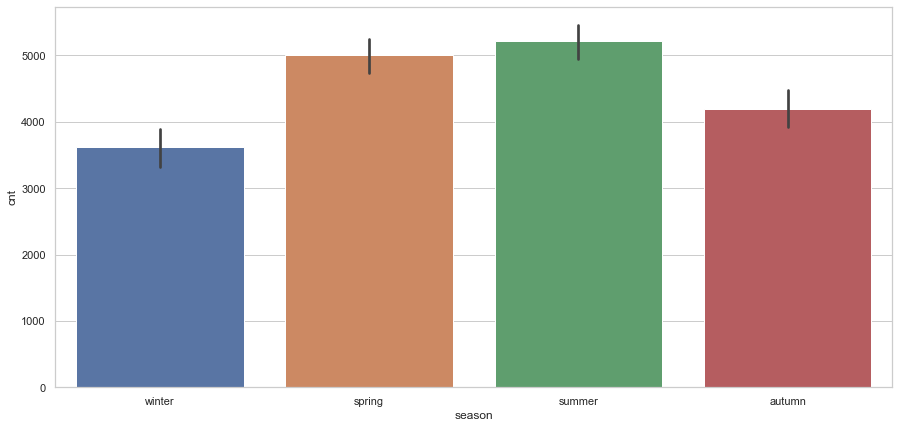

In [12]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
ax = sns.barplot(x = "season", y="cnt", data= df_bike)

 - Encoding numérico para la columna season

In [13]:
scale_mapper = {"winter":1, "spring":1, "summer":2, 'autumn':3}

df_bike['season_encoding'] = df_bike["season"].replace(scale_mapper)

- Hacemos una pequeña exploración preliminar con "season": ¿Cuántas reservas se hacen por estación y por tipo de cliente?

In [14]:
x= df_bike.groupby(['season']).agg({'cnt': ['sum'],'casual': ['sum'],'registered': ['sum']}).stb.subtotal()
x

,cnt,casual,registered
,sum,sum,sum
season,,,
autumn,771700,128069,643631
spring,909613,192850,716763
summer,958925,187579,771346
winter,650607,111454,539153
grand_total,3290845,619952,2670893


<AxesSubplot:xlabel='registered', ylabel='season'>

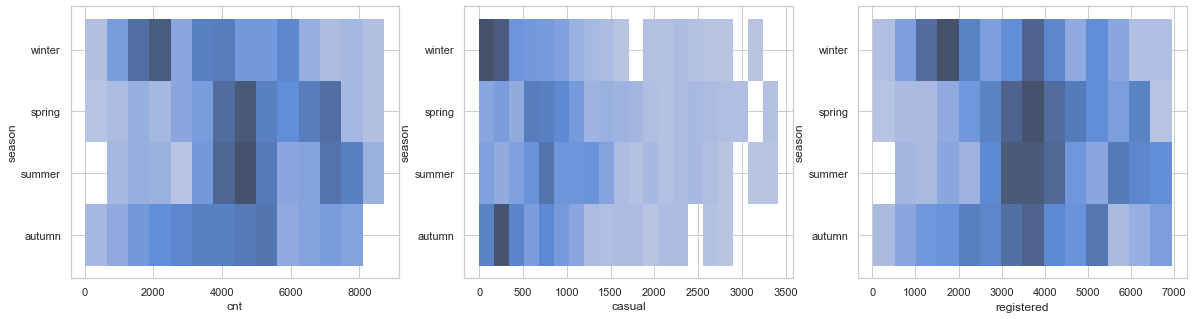

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(data=df_bike, x="cnt",y="season",ax=axes[0])
sns.histplot(data=df_bike, x="casual",y="season",ax=axes[1])
sns.histplot(data=df_bike, x="registered",y="season",ax=axes[2])

#HAY MAS RESERVAS DE GENTE REGISTRADA QUE CASUAL

--------

### 3. Columna "year" 

([<matplotlib.axis.XTick at 0x7fab3c238820>,
 [Text(0, 0, '2018'), Text(1, 0, '2019')])

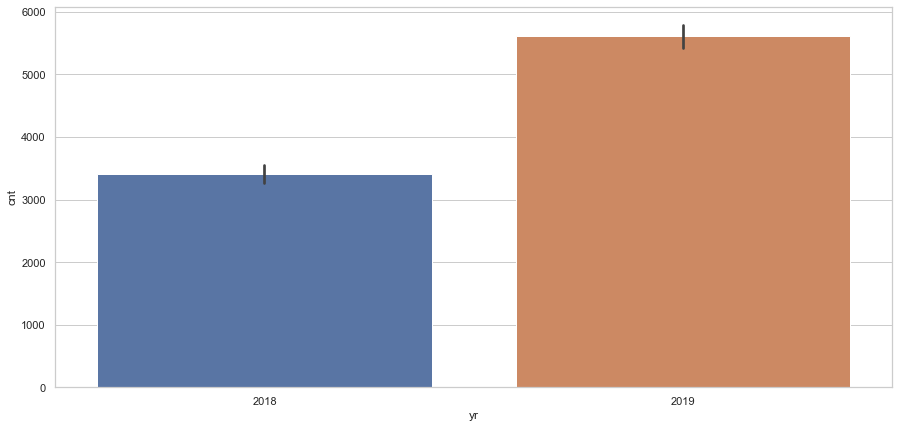

In [16]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
sns.barplot(x = "yr", y="cnt", data= df_bike)
plt.xticks([0, 1], ["2018", "2019"])

----

### 4. "Month" -> Exploración preliminar: reservas por mes.

<AxesSubplot:xlabel='mnth', ylabel='casual'>

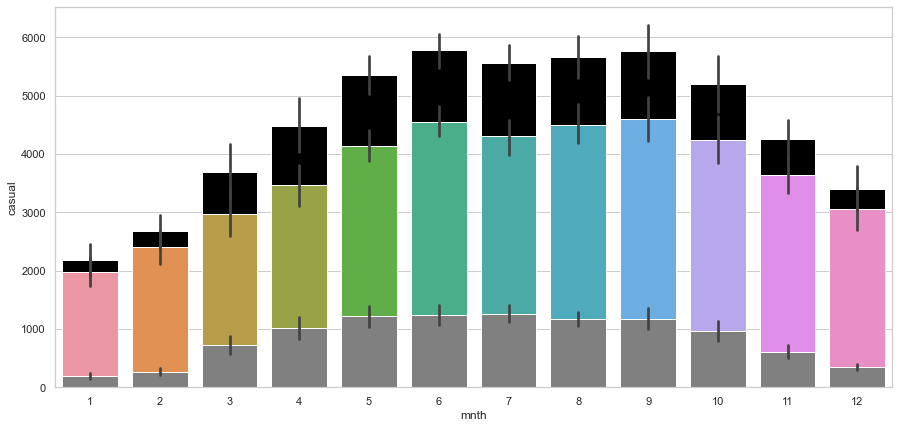

In [17]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
sns.barplot(x = "mnth", y ="cnt", data= df_bike, color = "black")

sns.barplot(x = "mnth", y="registered", data= df_bike)
sns.barplot(x = "mnth", y="casual", data= df_bike, color = "grey")
#plt.xticks([0, 1], ["2018", "2019"])

----

### 5. "Holiday"
1 = festivo /  0 = no festivo

df_bike.groupby(["holiday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)


Observamos: 
- Más reservas en NO FESTIVOS
- HAY MAYOR NUMERO DE RESERVAS LOS NO FESTIVOS
- Además:
    - SUMA EN NO FESTIVO
         - REGISTRADOS 2.614.817 RESERVAS EN NO FESTIVO
         - CASUAL 597.593 RESERVAS EN NO FESTIVO

    - SUMA EN FESTIVO
        - REGISTRADOS 56.076 RESERVAS EN  FESTIVO
        - CASUAL 22.359 RESERVAS EN NO FESTIVO

<AxesSubplot:xlabel='holiday', ylabel='count'>

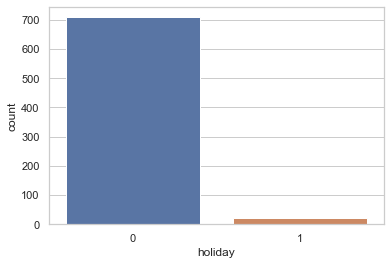

In [18]:
sns.countplot(x='holiday', data=df_bike)

-----

### 6. "Weekday" 
- 1-LUNES / 2-MARTES / 3-MIERCOLES / 4- JUEVES / 5-VIERNES / 6-SÁBADO / 0 -DOMINGO 

     Hay bastante igualdad entre los dias de la semana, siendo el ranking de más a menos reservas:
     ORDEN DE DIAS POR RESERVA: Viernes, jueves,sabado, miercoles,martes,lunes y domingo.


In [19]:
df_bike.groupby(["weekday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)

cnt                      ... registered                     
                min      max        sum  ...        max        sum      mean
weekday                                  ...                                
0             605.0   8227.0   444027.0  ...     5657.0   303506.0   2890.53
1              22.0   7525.0   455503.0  ...     6435.0   384719.0   3663.99
2             683.0   7767.0   469109.0  ...     6697.0   411266.0   3954.48
3             441.0   8173.0   471214.0  ...     6946.0   413960.0   4019.03
4             431.0   7804.0   485395.0  ...     6781.0   423935.0   4076.30
5            1167.0   8362.0   487790.0  ...     6917.0   409552.0   3938.00
6             627.0   8714.0   477807.0  ...     5966.0   323955.0   3085.29
grand_total  3976.0  56572.0  3290845.0  ...    45399.0  2670893.0  25627.62

[8 rows x 12 columns]

<AxesSubplot:xlabel='weekday', ylabel='registered'>

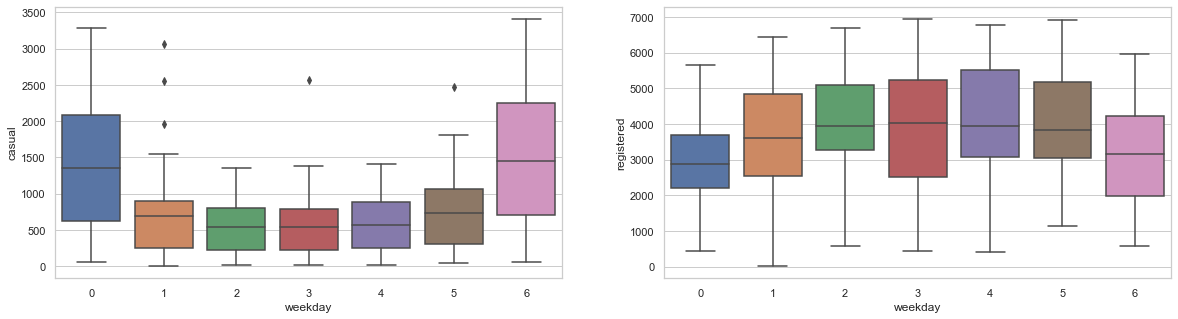

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(data=df_bike, x='weekday', y='casual',ax=axes[0])
sns.boxplot(data=df_bike, x='weekday', y='registered',ax=axes[1])

----

### 7. "workingday": 
- 1 - LABORABLE  /  0 -FIN DE SEMANA

In [21]:
df_bike.groupby(["workingday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)
# 1 dia laborable - hay muchas mas reservas en días laborables que festivos, más de el doble.

cnt                      ... registered                    
               min      max        sum  ...        max        sum     mean
workingday                              ...                               
0            605.0   8714.0  1000269.0  ...     5966.0   683537.0  2959.03
1             22.0   8362.0  2290576.0  ...     6946.0  1987356.0  3982.68
grand_total  627.0  17076.0  3290845.0  ...    12912.0  2670893.0  6941.71

[3 rows x 12 columns]

---

### 8. "weathersit": 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [22]:
weather = pd.DataFrame(df_bike[["cnt", "weathersit"]].groupby("weathersit"))

In [23]:
i = 0
lista2 = []
for i in range(len(df_bike["weathersit"].value_counts())):
    a = weather[1][i]["cnt"].sum()
    i = i+1
    lista2.append(a)

In [24]:
weathersit = pd.DataFrame(lista2)
weathersit["%"] = weathersit[0].apply(lambda x: x / df_bike.shape[0] * 100)
weathersit["Tipo"] = ["1", "2", "3"]

In [25]:
labelsX = ["1: Clear, Few clouds, Partly cloudy, Partly cloudy", "2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist", "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"]


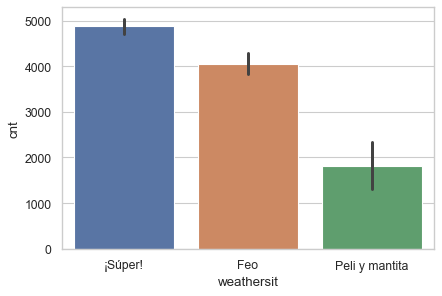

In [26]:
plt.figure(figsize=(6,4), dpi= 80)

sns.barplot(x = "weathersit", y = "cnt", data = df_bike)
plt.xticks([0, 1, 2], ["¡Súper!", "Feo", "Peli y mantita"]);


---

### 9. Temperatura, Sensación Térmica y Humedad

hay que hacer encoding con etiquetas para las graficas

In [27]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1


In [28]:
df_bike[['temp','atemp','hum']] = df_bike[['temp','atemp','hum']].round(1)

In [29]:
df_temp = df_bike[['temp','atemp']]
df_temp

,temp,atemp
0,14.1,18.2
1,14.9,17.7
2,8.1,9.5
3,8.2,10.6
4,9.3,11.5
...,...,...
725,10.4,11.3
726,10.4,12.8
727,10.4,12.1
728,10.5,11.6


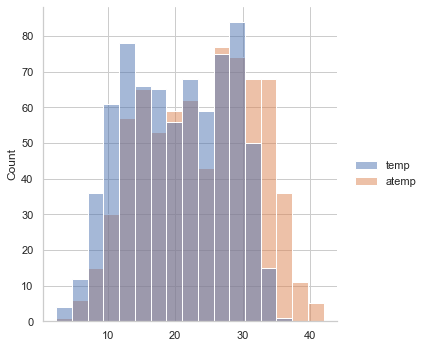

In [30]:
sns.displot(df_temp)

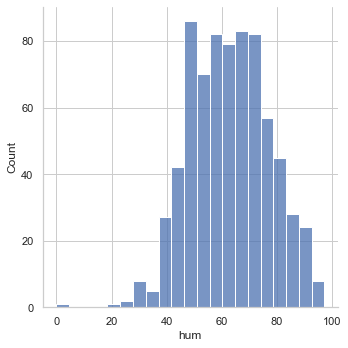

In [31]:
sns.displot(df_bike["hum"])

In [32]:
df_clima = df_bike[['temp','atemp','hum']]

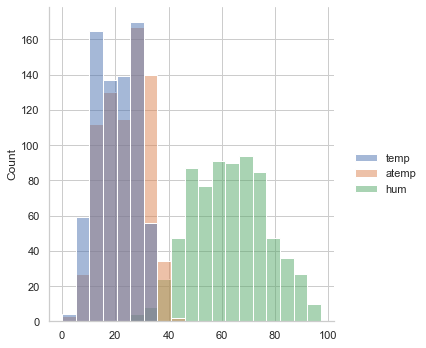

In [33]:
sns.displot(df_clima)

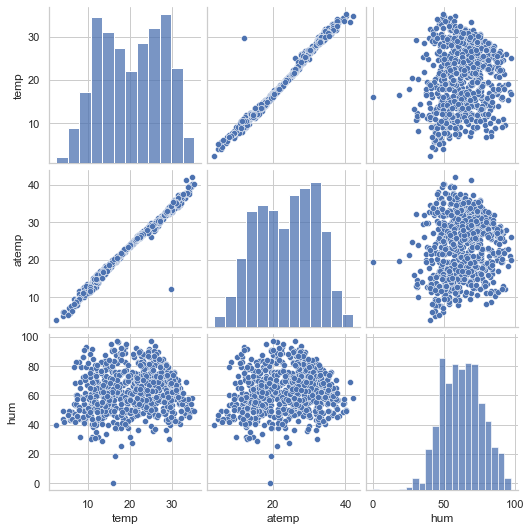

In [34]:
sns.pairplot(df_clima);

Voy a ver normalidad numéricamente

In [35]:
stats.shapiro(df_bike["atemp"])

ShapiroResult(statistic=0.9737697243690491, pvalue=3.6718658669165904e-10)

In [36]:
stats.shapiro(df_bike["temp"])

ShapiroResult(statistic=0.9657878279685974, pvalue=4.954737575085799e-12)

In [37]:
stats.shapiro(df_bike["hum"])

ShapiroResult(statistic=0.9933574795722961, pvalue=0.0025413876865059137)

Estas tres variables parecen normales

- Codificando variables

In [38]:
df_bike["temp_interval"] = pd.cut(df_bike["temp"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [40]:
df_bike["temp_interval_num"] = pd.cut(df_bike["temp"], 5, ordered=True)

In [42]:
#df_bike["atemp_interval"] = pd.cut(df_bike["atemp"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [43]:
df_bike["hum_interval"] = pd.cut(df_bike["hum"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [44]:
df_bike["hum_interval_num"] = pd.cut(df_bike["hum"], 5, ordered=True)

In [45]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]"
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]"


In [46]:
#df_interval = df_bike[["atemp_interval","temp_interval","hum_interval"]]
#df_interval

Voy a hacer un ordinal encoding

In [47]:
from sklearn.preprocessing import OrdinalEncoder
orden = ["very_low", "low", "medium", "high", "very_high"]

In [48]:
def ordinal_encoder(df, columna, orden_valores):
    
    # nos creamos un diccionario vacío para hacer el map después. 
    ordinal_dict = {}
    
    # iteramos por nuestra lista de valores usando el enumerate que recordamos nos devolvía también el índice o posición de cada elemento
    for i, valor in enumerate(orden_valores):
        ordinal_dict[valor]=i+1 # le sumamos uno a la posición para no tener valores de 0. 
    
    # aplicamos el map
    df[columna+"_ord"] = df[columna].map(ordinal_dict)
    return df

In [50]:
#ordinal_encoder(df_bike, "atemp_interval", orden)

In [51]:
ordinal_encoder(df_bike, "temp_interval", orden)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
2,3,2018-03-01,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1
3,4,2018-04-01,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1
4,5,2018-05-01,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,2019-12-27,autumn,1,12,27,0,4,1,2,10.4,11.3,65.3,23.458911,247,1867,2114,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
726,727,2019-12-28,autumn,1,12,28,0,5,1,2,10.4,12.8,59.0,10.416557,644,2451,3095,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
727,728,2019-12-29,autumn,1,12,29,0,6,0,2,10.4,12.1,75.3,8.333661,159,1182,1341,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
728,729,2019-12-30,autumn,1,12,30,0,0,0,1,10.5,11.6,48.3,23.500518,364,1432,1796,3,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2


In [52]:
ordinal_encoder(df_bike, "hum_interval", orden)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
2,3,2018-03-01,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1,3
3,4,2018-04-01,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1,4
4,5,2018-05-01,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,2019-12-27,autumn,1,12,27,0,4,1,2,10.4,11.3,65.3,23.458911,247,1867,2114,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
726,727,2019-12-28,autumn,1,12,28,0,5,1,2,10.4,12.8,59.0,10.416557,644,2451,3095,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
727,728,2019-12-29,autumn,1,12,29,0,6,0,2,10.4,12.1,75.3,8.333661,159,1182,1341,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
728,729,2019-12-30,autumn,1,12,30,0,0,0,1,10.5,11.6,48.3,23.500518,364,1432,1796,3,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3


- Saco gráficos

In [53]:
df_group_temp = df_bike.groupby(["temp_interval"]).agg({'cnt': ['sum']})

In [54]:
df_group_hum= df_bike.groupby(["hum_interval"]).agg({'cnt': ['sum']})
df_group_hum

,cnt
,sum
hum_interval,
very_low,2258
low,95327
medium,1224798
high,1595145
very_high,373317


Se acercan bastante a la normal.

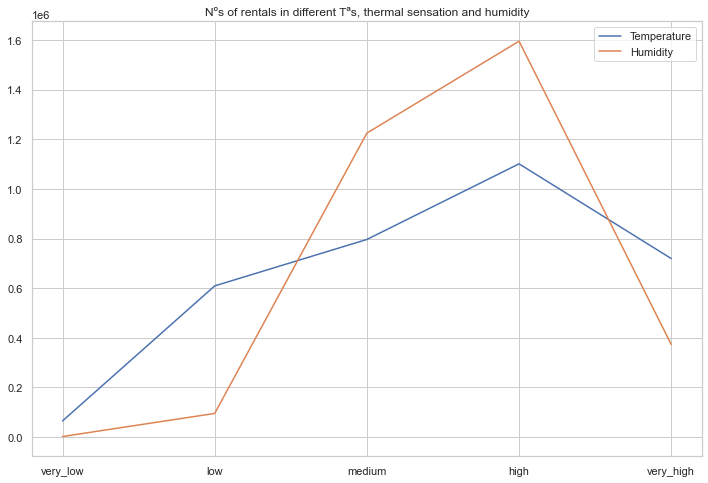

In [55]:
plt.figure(figsize=(12,8))
plt.plot(df_group_temp, label = "Temperature")
#plt.plot(df_group_atemp, label = "Thermal sensation")
plt.plot(df_group_hum, label = "Humidity")
plt.title("Nºs of rentals in different Tªs, thermal sensation and humidity")
plt.legend()
plt.show()

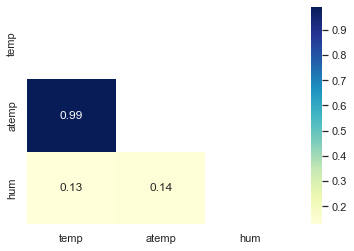

In [56]:
mask = np.triu(np.ones_like(df_clima.corr(), dtype=np.bool))
mask
sns.heatmap(df_clima.corr(),
            cmap = "YlGnBu", 
            mask = mask, # incorporamos la máscara en nuestro plot
           annot = True); 

---

### 10. "Windspeed": encoding

In [57]:
df_bike['wind_interval'] = pd.cut(df_bike['windspeed'], 5, labels=["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [58]:
df_bike['wind_interval'] = df_bike['wind_interval'].astype('object')

 - Al utilizar el método pd.cut nos devuelve una columna categórica, por eso lo cambiamos a tipo int64. Ahora ya tenemos codificada esta columna.

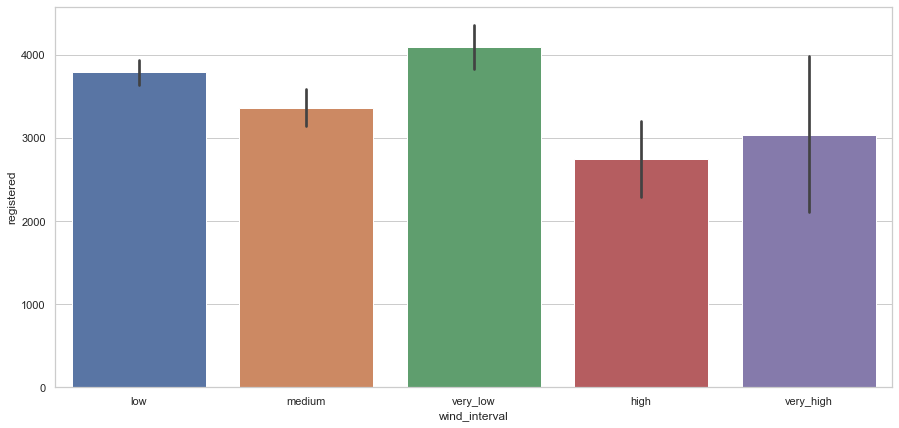

In [59]:
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="wind_interval", y="registered", data=df_bike)

 - Encoding numérico para la columna wind

In [60]:
scale_mapper = {"very low":0, "low":1, "medium":2, 'high':3, 'very high':4}

df_bike['wind_num_encoding'] = df_bike["wind_interval"].replace(scale_mapper)

----

### Últimas columnas: bicis registradas
- cnt (total por día)
- registered (reservadas por usuarios registrados)
- casual (bicis alquiladas por usuarios casuales) 

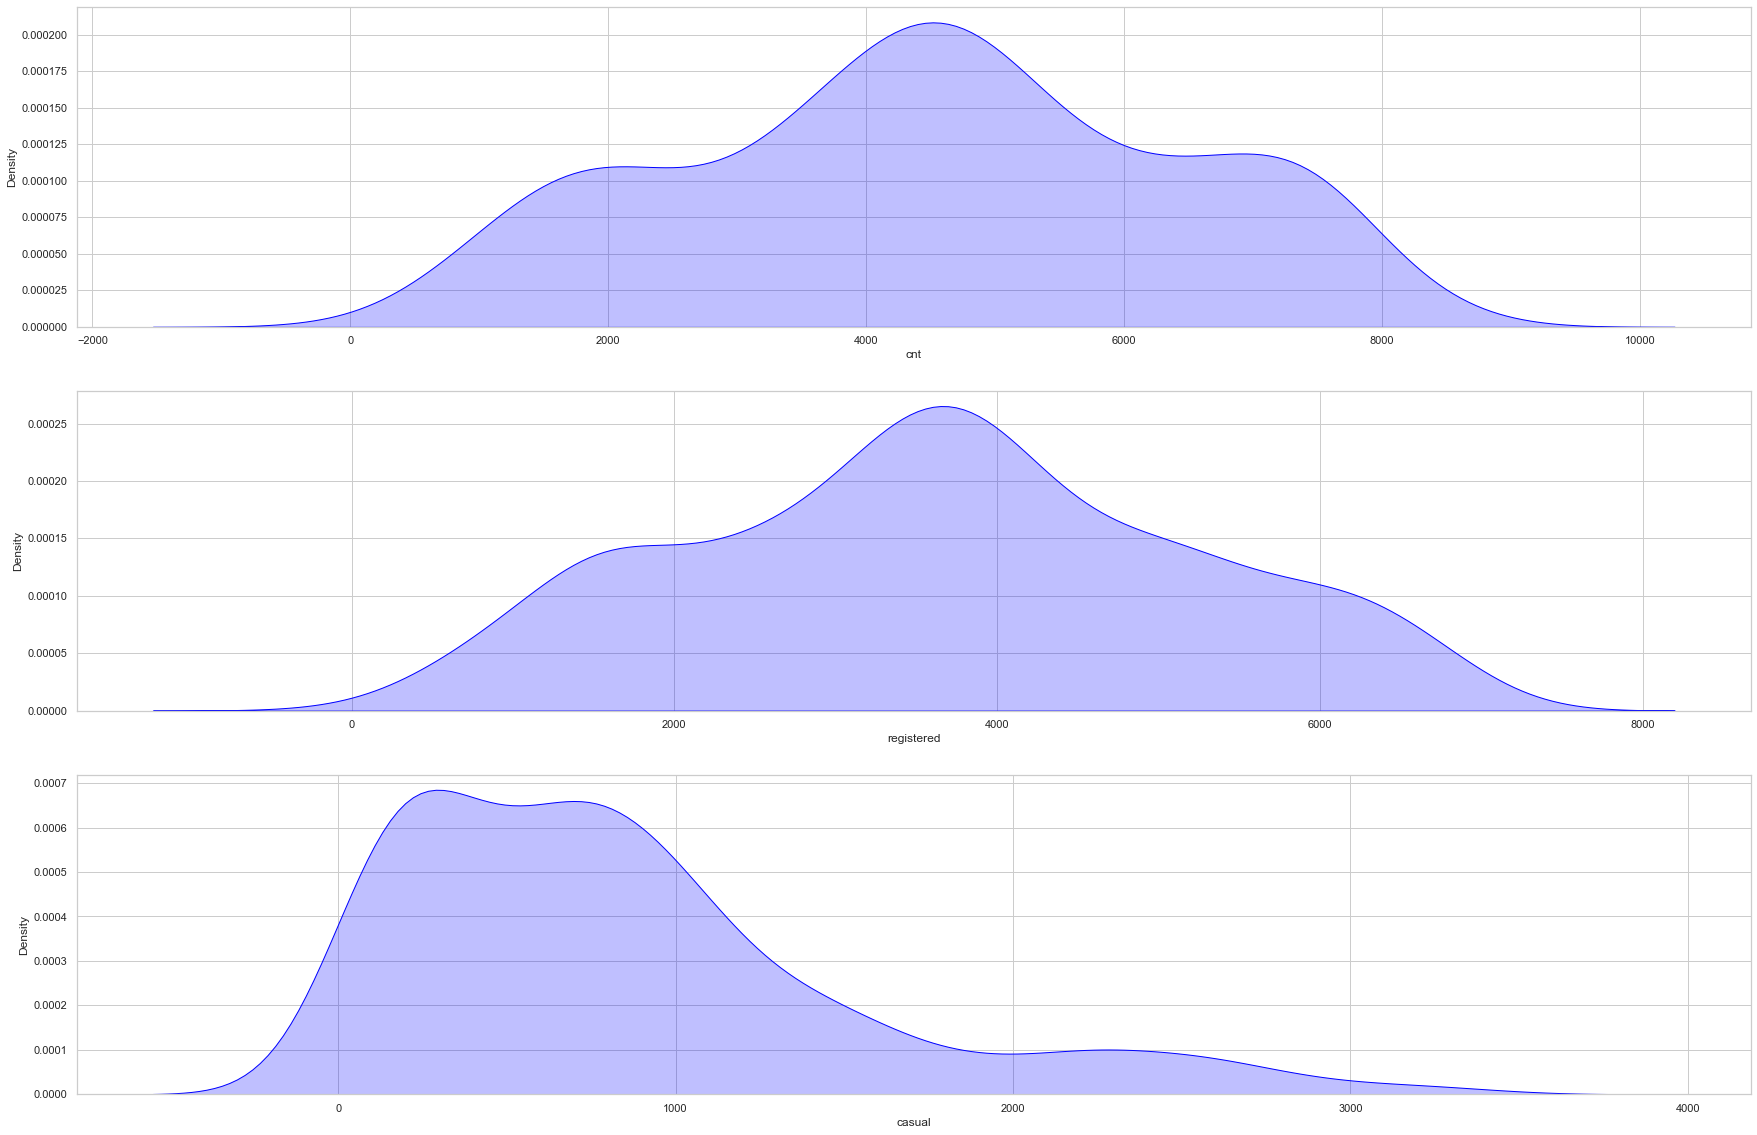

In [61]:
fig, axes= plt.subplots(3,1, figsize= (30, 20))
axes = axes.flat
sns.distplot(df_bike.cnt, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[0])
sns.distplot(df_bike.registered, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[1])
sns.distplot(df_bike.casual, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[2]);


-----

### ELIMINAMOS COLUMNAS SOBRANTES

Después de este proceso de exploración y limpieza decidimos borrar las columnas siguientes:
- Atemp (y sus derivadas) pues sus datos son muy similiares a los de temperatura. Usaremos esta segunda.
- "Dtday": pues ya hemos desglosado esa columna en día/mes/año
- "Instant": pues funciona como un índice, y usaremos el índice del dataframe

In [62]:
df_bike.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'day', 'holiday',
       'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'season_encoding',
       'temp_interval', 'temp_interval_num', 'hum_interval',
       'hum_interval_num', 'temp_interval_ord', 'hum_interval_ord',
       'wind_interval', 'wind_num_encoding'],
      dtype='object')

In [63]:
df_bike = df_bike.drop(columns= ['instant', 'dteday'], axis=1 )

In [64]:
df_bike.head()

,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord,wind_interval,wind_num_encoding
0,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5,low,1
1,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4,medium,2
2,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1,3,medium,2
3,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1,4,low,1
4,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3,low,1


### REORDENAMOS LAS COLUMNAS:

In [65]:
cols = ['season_encoding', 'season', 'yr', 'mnth', 'day', 'holiday', 'weekday', 'workingday',
                            'weathersit', 'temp', 'temp_interval', 'temp_interval_ord', "temp_interval_num", 'hum', 'hum_interval', 'hum_interval_num','hum_interval_ord', 'windspeed', 'wind_interval', 'wind_num_encoding','casual', 'registered', 'cnt']
len(cols) 

23

In [66]:
df_bike.head(2)

,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord,wind_interval,wind_num_encoding
0,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5,low,1
1,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4,medium,2


In [67]:
df_bike = df_bike.reindex(columns = cols)

# GUARDAMOS DATAFRAME FINAL

In [68]:
df_bike.to_csv("bikes_post_eda.csv")

------
------
----

# <font color = orange> SPRINT 2 - EMPIEZA LA REGRESIÓN

In [69]:
df = pd.read_csv("bikes_post_eda.csv", index_col = 0)
df.head()

,season_encoding,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval,temp_interval_ord,temp_interval_num,hum,hum_interval,hum_interval_num,hum_interval_ord,windspeed,wind_interval,wind_num_encoding,casual,registered,cnt
0,1,winter,0,1,1,0,6,0,2,14.1,low,2,"(8.98, 15.56]",80.6,very_high,"(77.76, 97.2]",5,10.749882,low,1,331,654,985
1,1,winter,0,1,2,0,0,0,2,14.9,low,2,"(8.98, 15.56]",69.6,high,"(58.32, 77.76]",4,16.652113,medium,2,131,670,801
2,1,winter,0,1,3,0,1,1,1,8.1,very_low,1,"(2.367, 8.98]",43.7,medium,"(38.88, 58.32]",3,16.636703,medium,2,120,1229,1349
3,1,spring,0,1,4,0,2,1,1,8.2,very_low,1,"(2.367, 8.98]",59.0,high,"(58.32, 77.76]",4,10.739832,low,1,108,1454,1562
4,1,spring,0,1,5,0,3,1,1,9.3,low,2,"(8.98, 15.56]",43.7,medium,"(38.88, 58.32]",3,12.522300,low,1,82,1518,1600


# REALIZAMOS DATAFRAME CON VARIABLES PARA PROBAR REGRESIÓN: solo datos originales // solo encoding

In [70]:
df.columns

Index(['season_encoding', 'season', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'temp_interval',
       'temp_interval_ord', 'temp_interval_num', 'hum', 'hum_interval',
       'hum_interval_num', 'hum_interval_ord', 'windspeed', 'wind_interval',
       'wind_num_encoding', 'casual', 'registered', 'cnt'],
      dtype='object')

In [71]:
df_encoded = [resto] LAURA

SyntaxError: invalid syntax (1896932853.py, line 1)

In [72]:
df_datos = df[['season', 'yr', 'mnth', 'day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', "hum", "windspeed", 'casual', 'registered', 'cnt']]

df_datos.head(2)

,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,winter,0,1,1,0,6,0,2,14.1,80.6,10.749882,331,654,985
1,winter,0,1,2,0,0,0,2,14.9,69.6,16.652113,131,670,801


In [73]:
df_num_datos = df_datos.select_dtypes(include = np.number)
df_num_datos

,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,0,1,1,0,6,0,2,14.1,80.6,10.749882,331,654,985
1,0,1,2,0,0,0,2,14.9,69.6,16.652113,131,670,801
2,0,1,3,0,1,1,1,8.1,43.7,16.636703,120,1229,1349
3,0,1,4,0,2,1,1,8.2,59.0,10.739832,108,1454,1562
4,0,1,5,0,3,1,1,9.3,43.7,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,12,27,0,4,1,2,10.4,65.3,23.458911,247,1867,2114
726,1,12,28,0,5,1,2,10.4,59.0,10.416557,644,2451,3095
727,1,12,29,0,6,0,2,10.4,75.3,8.333661,159,1182,1341
728,1,12,30,0,0,0,1,10.5,48.3,23.500518,364,1432,1796


# OUTLIERS

Hacer un describe

In [ ]:
pd.set_option("display.float_format",lambda x: "%3.f" %x) #Usamos esta linea de código para que no aparezca los exponenciales
df.describe().T

In [74]:
pd.set_option("display.float_format",lambda x: "%3.f" %x) #Usamos esta linea de código para que no aparezca los exponenciales
df_num_datos.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,730,0,1,0,0,0,1,1
mnth,730,7,3,1,4,7,10,12
day,730,16,9,1,8,16,23,31
holiday,730,0,0,0,0,0,0,1
weekday,730,3,2,0,1,3,5,6
workingday,730,1,0,0,0,1,1,1
weathersit,730,1,1,1,1,1,2,3
temp,730,20,8,2,14,20,27,35
hum,730,63,14,0,52,63,73,97
windspeed,730,13,5,2,9,12,16,34


In [75]:
df_num_datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   mnth        730 non-null    int64  
 2   day         730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  casual      730 non-null    int64  
 11  registered  730 non-null    int64  
 12  cnt         730 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 79.8 KB


In [ ]:
df.info()

Tenemos outliers? ¿Que hacemos con ellos?

PRIMERO SELECCIONA LAS VARIABLES NUMÉRCIAS

In [ ]:
df_numericas= df.select_dtypes(include="int64")

In [ ]:
len(df_numericas.columns)

13

In [76]:
len(df_num_datos.columns)

13

BOXPLOT PARA VER 

<AxesSubplot:>

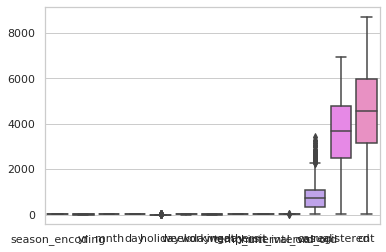

In [ ]:
sns.boxplot(data = df_numericas)

<AxesSubplot:>

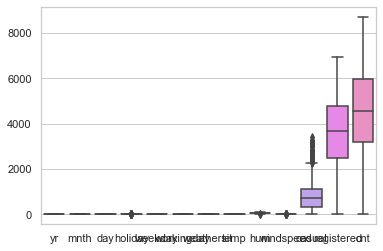

In [77]:
sns.boxplot(data=df_num_datos)

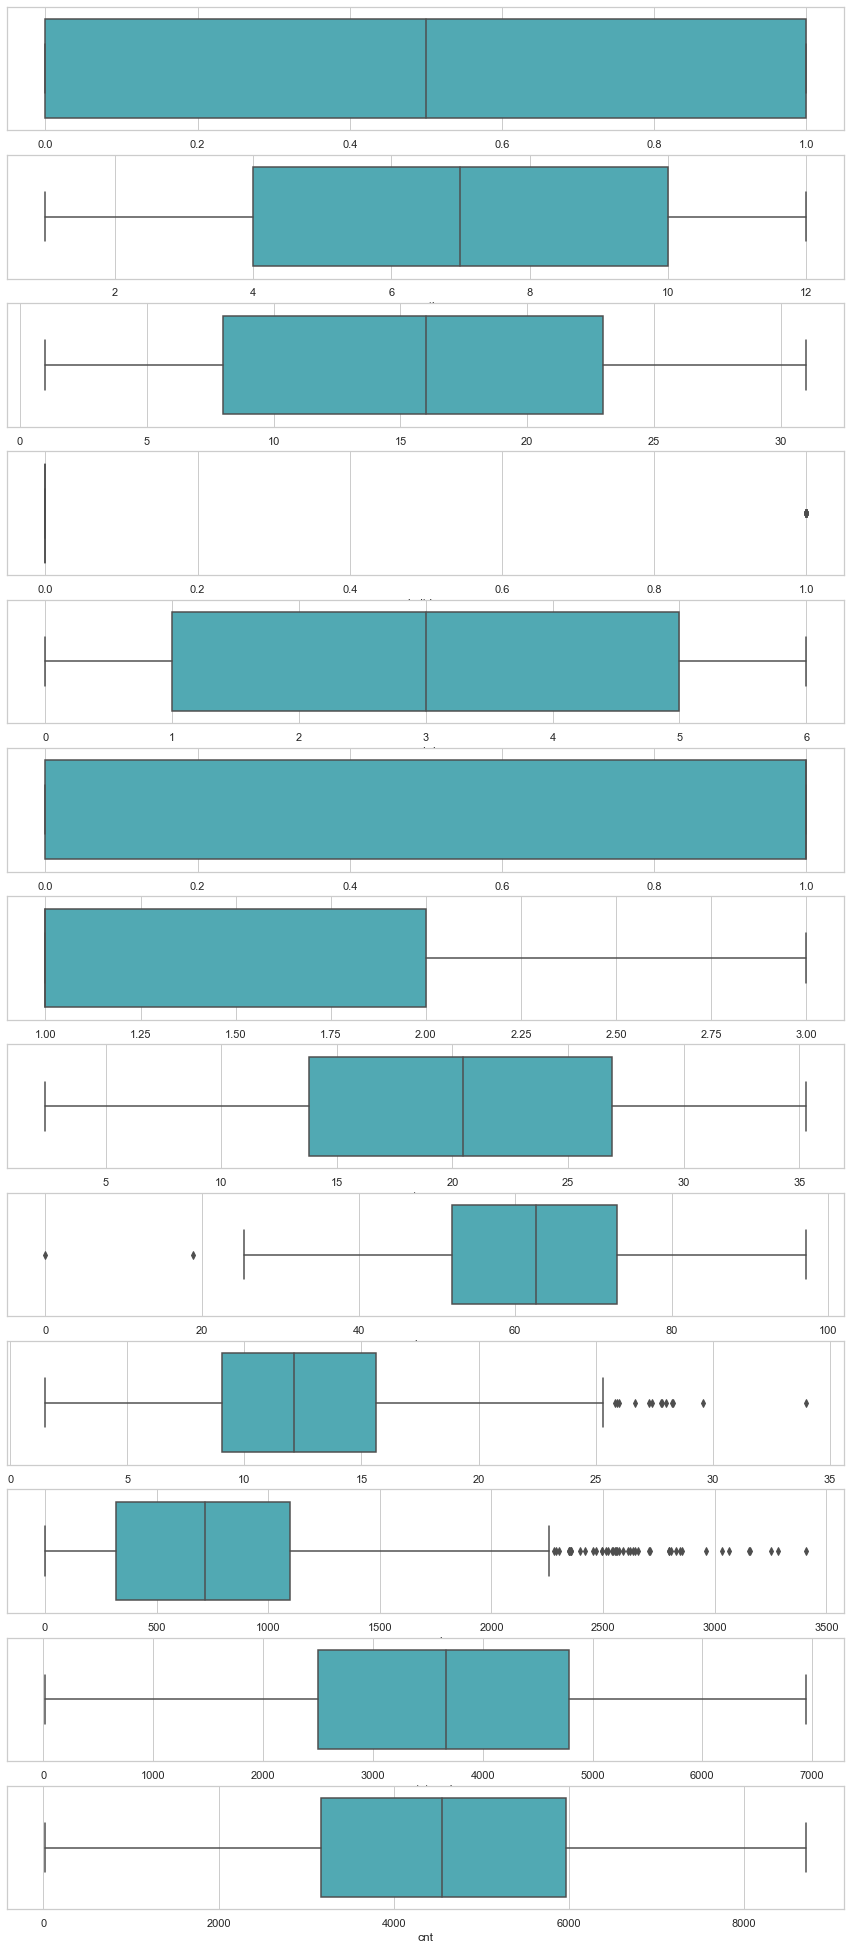

In [78]:
fig, axes = plt.subplots(13, 1, figsize=(15,35))
for i in range(len(df_num_datos.columns)):
    sns.boxplot(x = df_num_datos.columns[i], data = df,palette= "YlGnBu", ax=axes[i]); # para trazar una línea de densidad

plt.show()

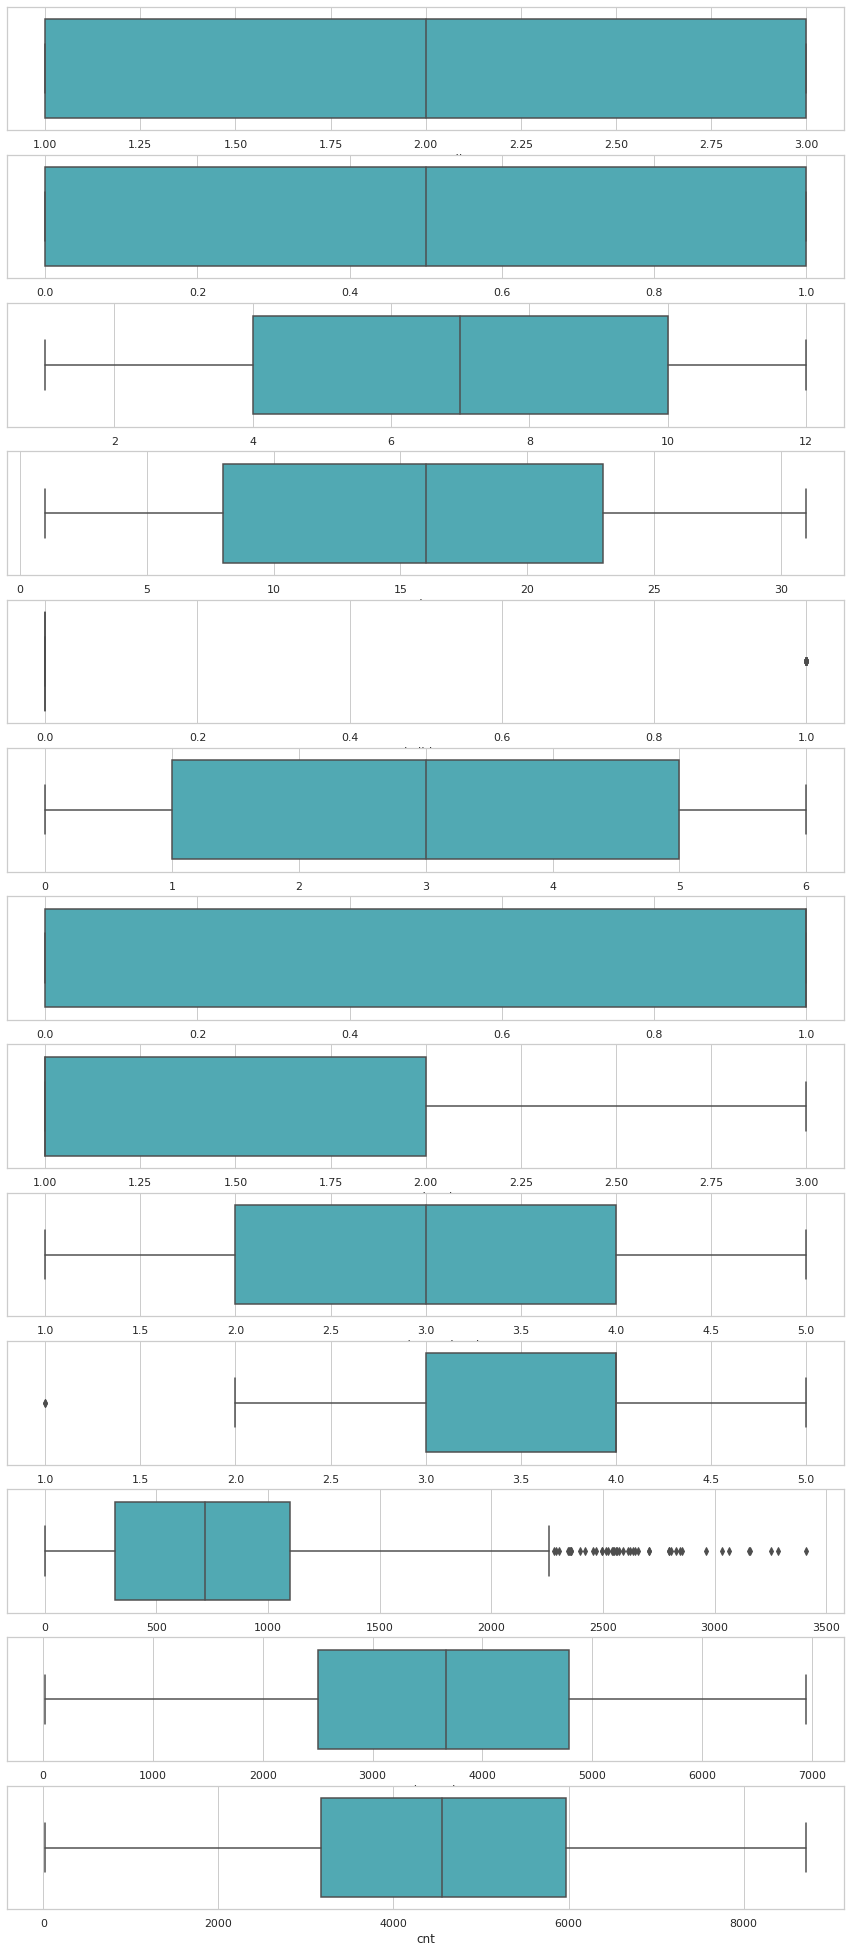

In [ ]:
fig, axes = plt.subplots(13, 1, figsize=(15,35))
for i in range(len(df_numericas.columns)):
    sns.boxplot(x = df_numericas.columns[i], data = df,palette= "YlGnBu", ax=axes[i]); # para trazar una línea de densidad

plt.show()

VOY A DETECTAR LOS OUTLIERS

In [79]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} 
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
    
    return dicc_indices 

In [92]:
lista_columnas = list(df_num_datos.columns)
ind = detectar_outliers(lista_columnas, df_num_datos)
print(ind)
for k, v in ind.items():
    mediana = df[k].median() 
    for i in v: 
        df.loc[i,k] = mediana

{'holiday': [16, 51, 104, 149, 184, 247, 282, 314, 327, 359, 366, 380, 415, 470, 512, 549, 610, 645, 680, 690, 723], 'hum': [49, 68], 'windspeed': [44, 49, 93, 94, 292, 382, 407, 420, 431, 432, 449, 665, 720], 'casual': [148, 183, 184, 196, 246, 281, 440, 446, 454, 455, 461, 468, 469, 475, 489, 496, 503, 504, 510, 511, 512, 517, 518, 524, 531, 532, 538, 539, 549, 559, 567, 580, 594, 608, 609, 616, 622, 629, 630, 636, 643, 657, 664, 679]}


VUELVE A REVISAR EL DESCRIBE PARA VER SI QUIERES SUSTITUIR UN VALOR

In [ ]:
df.describe().T

In [ ]:
# POR SI QUIERO CAMBIAR ALGUNA COLUMNA POR ALGUNA VALOR: DE MEDIANA , MEDIA, MODA
[df["price"].replace({x:71},inplace=True) for x in df["price"]]

#OTRAS OPCIONES
for k,v in ind.items():
    mediana= df[k].median()
    for i in v:
       df.loc[i,k] = mediana 

#OTRAS KNN METODO(VECINOS)


VUELVES A REVISAR BOXPLOT PARA VER SI YA NO TIENES OUTLIERS

IndexError: index 3 is out of bounds for axis 0 with size 3

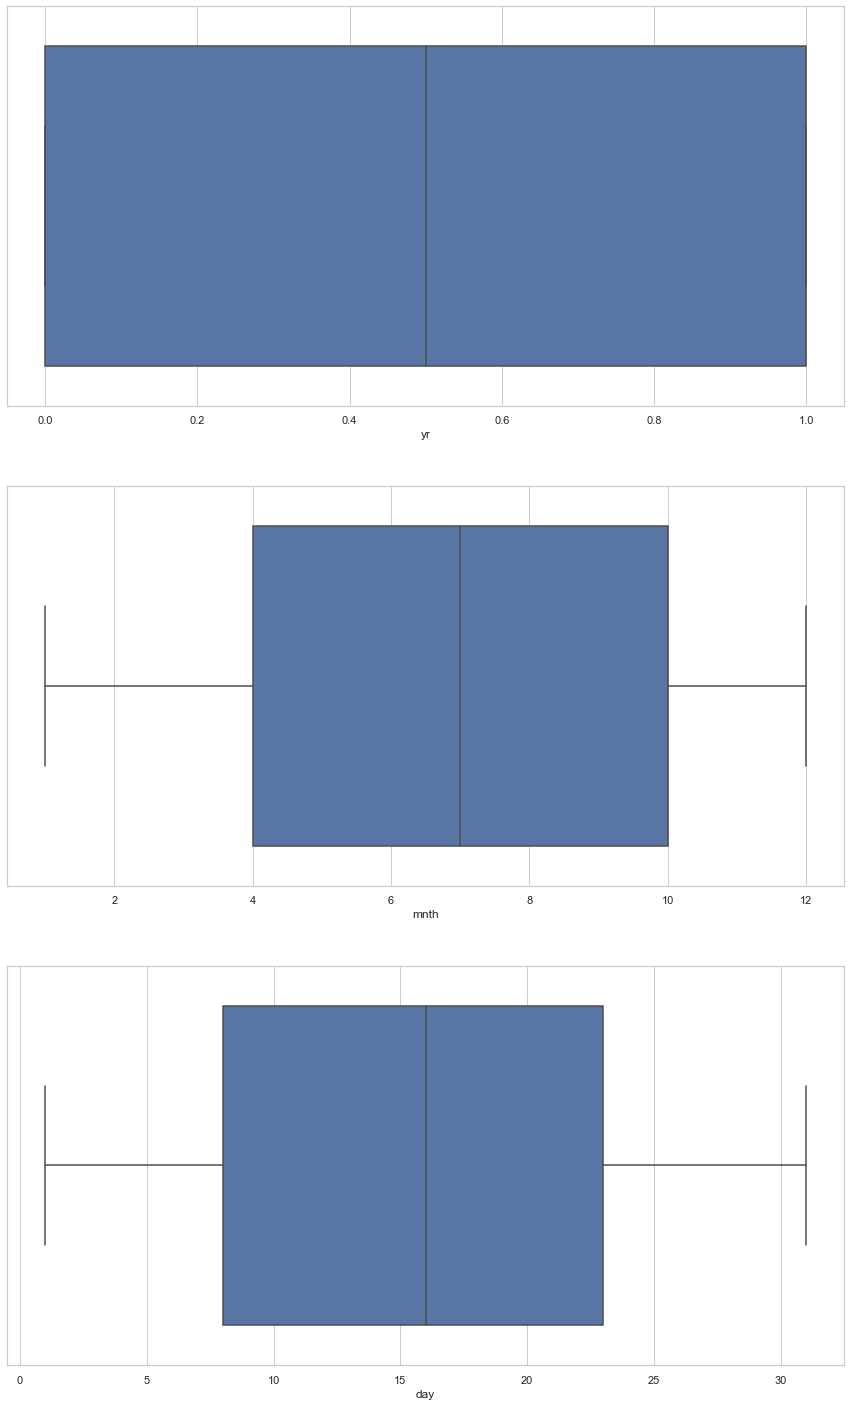

In [97]:
fig, axes = plt.subplots(3, 1, figsize=(15,25))

for i in range(len(df_num_datos.columns)):
    sns.boxplot(x = df_num_datos.columns[i], data = df, ax=axes[i]); # para trazar una línea de densidad

plt.show()

 - No quedan outliers en df_num_datos

# YA DEBE ESTAR TODO LIMPIO , CON ENCOGING, COLUMNAS NUMERICAS Y CATEGORICAS, TODO COMPLETITO PARA SIGUIENTE PASO

REGRESIÓN SIMPLE DE LAS 3 VARIABLES DEPENDIENTE :

Y = ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 EN GENERAL "CNT"?

Y1 = ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 CLIENTES registered ? 

Y2= ¿CUANTAS BICIS SE RESERVAN EN 2018 Y 2019 CLIENTES CASUAL?

### REGRESION LINEAL MULTIPLE CON VARIABLES NUMÉRICAS Y CATEGORIAS

🚨🚨 PRIMERO HAGO UN GROUPBY DE COMO VA A SER MI DF, POR QUE HEMOS INCLUIDO COLUMNAS EXTRAS , REDUNDANTES Y CATEGORICAS, QUE SOLO NOS HAN SERVIDO AL PRINCIPIO PARA LAS GRAFICAS.

In [ ]:

df = df.groupby(['col1', 'col2'])

HACEMOS LA CORRELACION DE LAS VARIABLES INDEPENDIENTES( AQUELLAS A QUIENES PREGUNTAMOS ESPERANDO LA RESPUESTA (Y))

In [ ]:
df.corr()

#solo se puede hacer con variables numericas
# de las mas correlacionadas, ¿con cual me quedo? con la mas importante.
# ¿Puede que nos quedemos con la temperatura y pasamos de la sensacion termica.

In [ ]:
sns.heatmap(numericas.corr()
            cmap="YIGnBu",
            annot= True);

#vamos a ver cual se realaciona mas, en caso que alguna fuera 0,7 o -0,7 eligo entre esas

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
corr = df_numericas.corr() 
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,mask = mask,xticklabels=corr.columns.values,yticklabels=corr.columns.values, annot= True )

Hacemos una ANOVA, por que a veces nos da informacion, cual es la diferencia entre hacer la anova y un skinlearning.

Objetivos de hacer una anova, por si te sale una variable no significativa pues no la smetemos en la regresión.

PAra ver de que depende mi modelo-.

In [ ]:
#Limpiamos los outliers , nosotras ya lo hemos hecho arriba

Comprobación asunciones

    normalidad: shapiro

In [ ]:
# Normalidad aqui SOLO VEMOS cnt por que es variable respuesta
#SOLO SE NORMALIZA LA RESPUESTA
#¿Son normales nuestros datos? Podemos verlo con un displot 
# Vemos Shapiro para testear la normalidad de los datos ( kologrov)

# Si shapiro es p> 0,05 no es significativo y nuestros DATOS NORMALES // P< 0,05 valores NO NORMALES no se puede rechazar HO
stats.shapiro (df["cnt"])

In [ ]:
# Si no son normales podemos transformar por : LOG, RAIZ CUADRADA Y BOX COX(
df["cnt"],lambda_ajustada= stats.boxcox(df["cnt"])

In [ ]:
#Hacemos de nuevo el shapiro a ver si lo hemos normalizado
stats.shapiro (df["cnt"])

    homocedasticidad :  test levene

    pvalor < 0,05 NO SIGNIFICATIVO, CUMPLE ASUNCIÓN , TIENEN VARIANZAS SIMILARES
    P valor > 0,05 SIGNIFICATIVO , no cumple asunción, NO TIENEN VARIANZAS SIMILARES

    

In [ ]:
#se aplica a categoricas y numericas
#primera categoricas

fig,axes = plt.subplots(1,4,figsize =(30,10))

axes= axes.float

colum_cat= df.select_dtypes(include=["object", "category"]).lista_columnas

for i,col in enumerate(colum_cat):
    sns,boxplot(
        x= col,
        y= "cnt",
        data= df_bike,
        palette= "tab10",
        ax= axes[i]
    )

In [ ]:
def datos_test_levene(columan,df):
    valoresr=df[columna].unique()
    d= {}

for x in valroes:
    d[x]= df[df(columna) == x]["cnt"]

Aqui nos saca los diferentes Dataframes

In [ ]:
sexo= detectar_test_levene("temperatura",df) #esta sobre la categorica creada low, high,...
smoker= detectar_test_levene("viento",df)
region= detectar_test_levene("humedad",df)
hijos= detectar_test_levene("season",df)

Ahora comprobamos levene para estos Df

In [ ]:
stats.levene(temperatura[0], temperatura[1], temperatura[2], temperatura[3], center = "median")
stats.levene(viento["low"], viento["high"], viento["2"], viento["3"], center = "median")
stats.levene(humedad["low"], humedad["high"], humedad["2"], humedad["3"], center = "median")
stats.levene(season["low"], season["high"], season["2"], season["3"], center = "median")

#ejemplo
levene_hijos = stats.levene(hijos['1'], hijos['2'], hijos['3'], hijos['4'], hijos['5'],  center='median')
levene_hijos

¿Cuantas de las variables categoricas cumplen homo? SI son todas genial, si no son todas, hay algunas hetero, estas hetero no deberiamos incluirlas en regresion lineal. Las ELIMINAMOS DEL DF, que vamos a presentar a la regresion.
Si solo tienes 1 homo, puedes plantear cambiar de modelo.

HOmocedasticidad PARA NUMERICAS

In [ ]:
numericas.head()

In [ ]:
# iniciamos los subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))

# definimos una lista de colores. Cada color corresponderá a una gráfica
lista_colores = ["cadetblue", "seagreen"]

# hemos creado una gráfica con varios subplots. Si queremos automatizar el proceso de relleno de cada uno de los plots
## podemos usar el método .flat. Lo que hace es aplanar los ejes para que queden en una única dimensión
## y luego los vamos rellenando. 
axes = axes.flat

# seleccionamos las columnas que queremos graficar
columnas_numeric = df.select_dtypes(include = np.number).drop('charges', axis=1)
columnas_numeric = columnas_numeric.columns

# iniciamos un for loop para no tener que escribir la misma línea de código muchas veces
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df,
        x = colum,
        y = 'charges',
        color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])

fig.tight_layout();

#¿Como vemos con este grafico las variables numericas, son homocedasticas?
#Todos los puntos deben estar alrededor de ma media Y = 0, tanto por arriba como por abajo. SON HOMOCEDASTICOS
#Si es tipo enbudo NO SON HOMOCEDASTICOS

In [ ]:
numericas.head()

In [ ]:
resultados= {}

numer= numericas.columns.drop(["children","charges"]) #hemos quitado esta por que ya es categorica

for col in numer:
    stat,p_value = levene(df[col], df.charges,center="median")

    resultados[col]= p_value

In [ ]:
resultados # aqui nos da los resutlados y podemos ver si son o no Homo

    Asuncion de independencia

    -
     MIS DATOS DEBEN SER INDEPENDIENTES ENTRE ELLOS (ES LO QUE BUSCAMOS)  chi- Cuadrado
     comparamos cnt(respuesta) con cada una de las variables independientes.

     PVALUE> 0,05 NUESTRAS VARIABLES SON INDEPENDIENTES
     PVALUE< 0,05 NO SON INDEPENDIENTES

     CRAMER TE DICE SI SON FUERTES O DEBILES  CERCA DE 0,6 ES FUERTE - 0,2 ES DEBIL

In [ ]:
columas = df.lista_columns
columnas

In [ ]:
combinaciones= list(itertools.combinations(columnas,2))#combinaciones de 2 en dos
combinaciones #te las da sin repeticion

In [ ]:
for par in combinaciones:
    crosstab,test_result, expected= rp.crosstab(df[par[0]],df[par[1]],
                                                test= "chi-square",
                                                expected_freqs=True,
                                                prop= "cell")

print("----------------", par[0]," + " , par[1],"-------------------")
print(test_results)

# AQUI VAMOS A VER QUIENES SON INDEPENDIENTES Y QUIENES NO
#¿QUE HACEMOS CON ELLAS? LAS QUITAMOS DEL MODELO O LAS TRANSFORMAMOS ¿TIENE SENTIDO? PERDEMOS SENTIDO EN NUESTRO DATASET

    ANOVA lo hacemos para ver nivel de significancia de mi variable respuesta, con las independientes.
    #Vamos a meter todas variables y para comprobar quien tiene mucho significado

In [ ]:
ls= ols("charge - sex + bmi + children",data=df).fit()
sm.stats.anova_lm(ls)

ls.summary() # esto es lo importante  R-square-

# miro R.square : 0.111,...esto es la % de probabilidad que tiene este conjunto de variables independientes
#  de contestar a mi variable respuesta

# si pvalor< 0,05 entonces es significativa para la prediccion 
# OJO al intercept que es el punto de referencia. Va a coger por orden alfabeticos de las variables categoricas.

#¿Que informacion importante?
#coef podemos ver como la intensidad en la que influye
#pvalor < 0,05

    HACER VIF

In [ ]:
VIF

# cercano a 1 no hay relación
# de 1 a 5 relación moderada
# mas de 5 fuerte relacion

    ENCODING

In [ ]:
#¿TIENE ORDEN O NO? ¿Sobre que  columnas hacemos encoding? 
#Orden= dummies para aquellas dnd no hay diferencias entre sus categorias / one hot, para aquellas dnd si haya mucha diferencia entre sus categorias.
#(Por lo que hay que ver primero las diferencas entre columnas y si misma)
# si tiene orden= label, map ordinal

In [ ]:
dummies_sex = pd.get_dummies(df["sex"], prefix_sep= "_", prefix="sex", dtype=int)

In [ ]:
df[dummies_sex.columns] = dummies_sex

In [ ]:
#Aqui eliminamos las categoricas que estan en object
df.drop(["sex", "region"]axis=1,inplace=True)

In [ ]:
#utilizamos  map por que solo tiene una categoria
mapa= {"no":0, "yes":1}

df["smoker"]= df["smoker"].map(mapa)


### ANTES DEBERIAMOS HACER UN ENCODING A LAS CATEGORICAS, SI NO, NO ACEPTARÁ ESTOS DATOS

### NO TENEMOS POR QUE ESTANDARIZAR

In [ ]:
df_copia = df.copy()

# iniciamos el método
le = LabelEncoder()

# lo aplicamos a todo nuestro dataframe 
for col in label_encoded_df.select_dtypes(include='O').columns:
    label_encoded_df[col]=le.fit_transform(label_encoded_df[col])



### REGRESION MULTIPLE LINEAL: QUEREMOS SABER EL NUMERO TOTAL DE RESERVAS DE BICIS Y SI LAS VARIABLES INDEPENDIENTES, NOS AYUDAN A CONOCERLO Y EN QUE MEDIDA, SEGÚN LA RESPUESTA DEL MODELO.

In [ ]:
x =df_numericas.drop(columns = ['cnt','registered', 'casual' ]) #Quitamos nuestra variable dependiente.
y = df_numericas['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression()
# Ajustamos el modelo
LR.fit(x_train,y_train)
y_prediction_train =  LR.predict(x_train)
Adj_r2_train = 1 - (1-r2_score(y_train,y_prediction_train)) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)

y_prediction =  LR.predict(x_test)
Adj_r2_test = 1 - (1-r2_score(y_test, y_prediction)) * (x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)

# Para el conjunto de entrenamiento las méticas han sido
print('Para el conjunto train:---------------')
print('El valor de r2 score es ',r2_score(y_train,y_prediction_train))
print('El valor de r2 score adjusted es ',Adj_r2_train)
print('El MAE es',mean_absolute_error(y_train,y_prediction_train))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_train,y_prediction_train)))


# Para el conjunto de test las métricas han sido
print('Para el conjunto test:---------------')
print('El valor de r2 score es ',r2_score(y_test,y_prediction))
print('El valor de r2 score adjusted es ',Adj_r2_test)
print('El MAE es',mean_absolute_error(y_test,y_prediction))
print('EL RMSE es ',np.sqrt(mean_squared_error(y_test,y_prediction)))

In [ ]:
y_pred_test.reset_index(inplace=True) # Se me crea nueva columna y luego la dropeo

    FORMA DE ANA

In [ ]:
x =df_numericas.drop(columns = ['cnt','registered', 'casual' ]) #Quitamos nuestra variable dependiente.
y = df_numericas['cnt']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Creamos la regresión lineal
LR = LinearRegression()
# Ajustamos el modelo
LR.fit(x_train,y_train)

In [ ]:
#obligatorio definir antes para la fincion
y_prep_test= lr.predict(x_test)
y_prep_train = lr.predict(x_train)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    return df

    #nos fijamos en el rmse y rcuadrado
    #RMSE es cuanto me equivoco

In [ ]:
result= metricas(y_test,y_train,y_pred_train,y_pred_test ) # y me dice los resultados de train y test
#el RMSE puede ser positivo o negativo en funcion del problema, hay que mirar con un describe max y min
result

In [ ]:
results.style.background_gradient(cmap="coolwarm") # te da de colores DF

In [ ]:
#¿Cuando ocurre overfiting? Cuando se ha aprendido de memoria mis datos

#cuando las metricas en en train sean mucho mejores que en test rcuadrados altos y rmse bajos
#underfiting lo contrario
#ambas es que hay un modelo predictivo basura

# se soluciona añadiendo variables predictoras (aprende a coser con una prenda, o aprende con muchas prendas)
#over mas datos y menos variables predictoras
#under mas filas en nuestro df y mas variables predictoras

#no queremos ninguno de los dos

UNA VEZ QUE CONOZCAMOS ESTOS DATOS, PODEMOS VER SI PODRIAN MEJORAR Y DEBEMOS ESTANDARIZAR Y PROBAR DE NUEVO